In [1]:
# Load original dataset
import pandas as pd

file_path = '../../data/lm2.csv'
data_df = pd.read_csv(file_path)
print('Num of features: %s' % len(data_df.columns.values))
data_df.head()

Num of features: 53


,Label,Outer left eyebrow-x,Outer left eyebrow-y,Middle left eyebrow-x,Middle left eyebrow-y,Inner left eyebrow-x,Inner left eyebrow-y,Inner right eyebrow-x,Inner right eyebrow-y,Middle right eyebrow-x,...,Lower lip inner middle-x,Lower lip inner middle-y,Lower lip outer middle-x,Lower lip outer middle-y,Chin middle-x,Chin middle-y,Left ear lobe-x,Left ear lobe-y,Right ear lobe-x,Right ear lobe-y
0,HAPPY,79.4496,557.174,176.086,436.378,433.784,444.431,675.375,452.484,908.914,...,546.527,1161.15,554.580,1225.58,570.686,1499.38,NaN,NaN,NaN,NaN
1,ANGER,90.6538,530.365,209.062,467.214,465.614,518.524,678.749,502.736,883.991,...,603.953,1118.97,595.863,1130.30,590.090,1467.86,NaN,NaN,NaN,NaN
2,SURPRISE,86.5398,546.773,117.065,398.508,378.710,415.951,710.126,398.508,915.081,...,544.418,1261.94,535.696,1331.71,548.779,1567.19,36.7298,978.497,1078.27,947.863
3,FEAR,104.6750,518.635,179.731,439.410,384.049,435.240,680.102,443.580,851.062,...,555.009,1223.32,563.349,1335.91,571.688,1552.74,NaN,NaN,NaN,NaN
4,DISGUST,115.4420,526.418,241.744,459.320,435.145,514.577,648.280,490.895,845.627,...,585.227,1116.66,589.076,1150.04,596.969,1438.16,74.5932,913.326,NaN,NaN


## Remove NaN and Drop Static Landmarks
These features are not important for identifying emotions. They can act as anchors which are static to other landmarks, in our case we use the nose tip (we normalize this distance later).

In [2]:
def variety(lbl):
    return [lbl+'-x', lbl+'-y']

print('Num of features:\t%s' % len(data_df.columns.values))

# Drop features potentiall unuseful features 
drops = variety('Right nose peak')  + variety('Left nose peak')    + \
        variety('Left temple')      + variety('Right temple')      + \
        variety('Right ear lobe')   + variety('Left ear lobe')     + \
        variety('Nose saddle left') + variety('Nose saddle right') + \
        variety('Chin middle')
        
# errors = 'ignore' because it will throw if columns aren't there
data_df = data_df.drop(drops, axis=1, errors='ignore')
print('after drop un-used\t%s' % len(data_df.columns.values))

# Drop features where 'NaN' is present
data_df = data_df.dropna(axis=1, how='any')
print('after drop NaN\t\t%s' % len(data_df.columns.values))
data_df.head()

Num of features:	53
after drop un-used	35
after drop NaN		35


,Label,Outer left eyebrow-x,Outer left eyebrow-y,Middle left eyebrow-x,Middle left eyebrow-y,Inner left eyebrow-x,Inner left eyebrow-y,Inner right eyebrow-x,Inner right eyebrow-y,Middle right eyebrow-x,...,Upper lip outer middle-x,Upper lip outer middle-y,Right mouth corner-x,Right mouth corner-y,Upper lip inner middle-x,Upper lip inner middle-y,Lower lip inner middle-x,Lower lip inner middle-y,Lower lip outer middle-x,Lower lip outer middle-y
0,HAPPY,79.4496,557.174,176.086,436.378,433.784,444.431,675.375,452.484,908.914,...,558.606,1072.57,796.171,1072.57,550.553,1104.78,546.527,1161.15,554.580,1225.58
1,ANGER,90.6538,530.365,209.062,467.214,465.614,518.524,678.749,502.736,883.991,...,599.810,1086.88,816.893,1110.57,599.810,1110.57,603.953,1118.97,595.863,1130.30
2,SURPRISE,86.5398,546.773,117.065,398.508,378.710,415.951,710.126,398.508,915.081,...,531.336,1113.67,714.487,1187.80,540.057,1148.56,544.418,1261.94,535.696,1331.71
3,FEAR,104.6750,518.635,179.731,439.410,384.049,435.240,680.102,443.580,851.062,...,559.179,1044.03,763.497,1085.72,563.349,1077.38,555.009,1223.32,563.349,1335.91
4,DISGUST,115.4420,526.418,241.744,459.320,435.145,514.577,648.280,490.895,845.627,...,593.023,1051.36,837.733,1094.78,596.969,1098.73,585.227,1116.66,589.076,1150.04


In [3]:
# Compute the distance from all points to the nose tip (intuition: nose tip position is likely to be similar regardless of emotion)
import math

def get_euclidean_distance(x1, x2, y1, y2):
    '''
    Return the euclidean distance between two points
    '''
    term_1 = x1 - x2
    term_2 = y1 - y2
    return math.sqrt(term_1 ** 2 + term_2 ** 2 )

def get_manhattan_distance(x1, x2, y1, y2):
    '''
    Return the manhattan distance between two points
    '''
    term_1 = math.fabs(x1 - x2)
    term_2 = math.fabs(y1 - y2)
    return term_1 + term_2

# Create new dataset using distance from each landmark to the nose tip as features
all_landmarks = ['Outer left eyebrow', 'Middle left eyebrow', 'Inner left eyebrow', 'Inner right eyebrow', 'Middle right eyebrow', 'Outer right eyebrow', 'Left temple', 'Outer left eye corner', 'Inner left eye corner', 'Inner right eye corner', 'Outer right eye corner', 'Right temple', 'Nose saddle left', 'Nose saddle right', 'Left nose peak', 'Right nose peak', 'Left mouth corner', 'Upper lip outer middle', 'Right mouth corner', 'Upper lip inner middle', 'Lower lip inner middle', 'Lower lip outer middle', 'Chin middle', 'Left ear lobe', 'Right ear lobe']
valid_landmarks = []

# Remove landmarks which were previously removed due to undefined values ('NaN')
columns = data_df.columns.values
for landmark in all_landmarks:
    if landmark + '-x' in columns and  landmark + '-y' in columns:
        valid_landmarks.append(landmark)
        
# Create dictionary to temporarily hold distance values
d = {}
for landmark in valid_landmarks:
    d[landmark + '-distance'] = []
    
# For each feature, compute distance from nose tip
for _, row in data_df.iterrows():
    for landmark in valid_landmarks:
        nose_x, nose_y = (row['Nose tip-x'], row['Nose tip-y'])
        landmark_x, landmark_y = (row[landmark + '-x'], row[landmark + '-y'])
        distance = get_euclidean_distance(landmark_x, nose_x, landmark_y, nose_y)
        d[landmark + '-distance'].append(distance)
        
# Remove the nose-tip?
# data_df = data_df.drop(['Nose tip-x', 'Nose tip-y'], axis=1, errors='ignore')

## Distance to Nose Tip 
Intuition: nose tip position is likely to be similar regardless of emotion.

In [4]:
# Create new dataframe (with distance from each feature to nose tip)
new_df = pd.concat([data_df[['Label']], pd.DataFrame.from_dict(d)], axis = 1)
new_df.head()

,Label,Inner left eye corner-distance,Inner left eyebrow-distance,Inner right eye corner-distance,Inner right eyebrow-distance,Left mouth corner-distance,Lower lip inner middle-distance,Lower lip outer middle-distance,Middle left eyebrow-distance,Middle right eyebrow-distance,Outer left eye corner-distance,Outer left eyebrow-distance,Outer right eye corner-distance,Outer right eyebrow-distance,Right mouth corner-distance,Upper lip inner middle-distance,Upper lip outer middle-distance
0,HAPPY,297.831252,455.150020,298.851438,450.063255,323.435445,276.559753,341.009790,583.438327,568.227334,467.936613,572.910552,471.069484,566.272147,310.067169,220.175190,188.180022
1,ANGER,339.238567,381.048521,317.530065,386.245112,310.725384,240.701545,251.698214,560.782249,508.857336,496.060458,608.893667,471.410580,566.459261,324.373455,232.105614,208.438757
2,SURPRISE,310.840237,498.995762,327.111617,520.263588,343.942428,372.863253,442.563158,645.863384,636.777941,460.359724,565.867471,471.624484,616.776342,347.370657,259.428104,224.594412
3,FEAR,325.703578,458.191004,324.707988,438.606055,319.023552,360.966256,473.712145,562.032930,543.325541,492.100778,562.427710,482.531825,584.070368,309.083194,215.414073,181.879798
4,DISGUST,330.512636,373.931348,328.746551,386.481891,319.889063,250.835962,284.434519,517.168617,537.457441,455.743065,559.944867,493.541260,578.315301,359.265905,234.576694,187.214468


# Normalization and Dimensionality Reduction
Normalize values after computing their distance to a static point (nose tip for now). Then, we run these points through PCA and tSNE methods. 

tSNE performs better so we move forward with that dataframe.

In [5]:
features = [x != 'Label' for x in new_df.columns.values]

# Separating out the features
values = new_df.loc[:, features].values

# Separating out the label
labels = new_df.loc[:,['Label']].values

In [6]:
# Scale values (mean = 0 and variance = 1)
from sklearn.preprocessing import normalize

values = normalize(values, axis=0)

In [7]:
# Set the number of columns we want to reduce
num_of_columns = 14
column_names = ['Col %s' % (i + 1) for i in range(num_of_columns)]                                     

In [8]:
from sklearn.decomposition import PCA

# Use PCA to reduce dimensionality
pca = PCA(n_components=num_of_columns, whiten = True)
principal_components = pca.fit_transform(values)
principal_df = pd.DataFrame(data = principal_components, columns = column_names)

# Add the label to the dataframe with the principal components
principal_labels_df = pd.concat([new_df[['Label']], principal_df], axis = 1)
principal_labels_df.head()

,Label,Col 1,Col 2,Col 3,Col 4,Col 5,Col 6,Col 7,Col 8,Col 9,Col 10,Col 11,Col 12,Col 13,Col 14
0,HAPPY,-0.488233,0.164605,0.084666,-1.244050,-0.696989,-0.641906,0.350272,-0.554375,-0.282240,-0.114033,-1.675602,0.106994,-0.728105,0.533165
1,ANGER,-0.709971,-0.308697,-1.424850,0.557993,1.083411,0.333080,0.112275,-1.526441,-1.217706,-1.098153,1.443898,0.423606,2.084312,1.402473
2,SURPRISE,0.281406,1.572144,0.413689,-1.145305,-2.179174,-1.299749,-0.273081,-1.081012,-0.057646,0.798109,0.216582,-0.362036,0.129865,1.531268
3,FEAR,-0.047833,0.784718,1.580889,1.037307,-0.335277,-1.182441,-1.309762,0.553971,0.248721,-1.302502,-1.681033,0.405270,-2.695630,-0.564704
4,DISGUST,-0.589718,-0.364557,-0.881238,0.864712,-0.241180,1.936002,-0.677493,-1.333136,1.020877,-0.373555,1.260352,-0.101358,2.080482,-0.792858


In [9]:
# Visualize the PCA 2d projection
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(column_names[0], fontsize = 12)
ax.set_ylabel(column_names[1], fontsize = 12)
ax.set_title('2 component PCA', fontsize = 15)

targets = ['ANGER', 'DISGUST', 'FEAR', 'HAPPY', 'SADNESS', 'SURPRISE']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for target, color in zip(targets, colors):
    indexes_to_keep = principal_labels_df['Label'] == target
    ax.scatter(
        principal_labels_df.loc[indexes_to_keep, column_names[0]],
        principal_labels_df.loc[indexes_to_keep, column_names[1]],
        c = color,
        s = 50
    )
ax.legend(targets)
ax.grid()

In [10]:
from sklearn import manifold

# Use tSNE to reduce dimensionality
tsne = manifold.TSNE(n_components=num_of_columns, init='pca', random_state=0, method='exact')
tsne_components = tsne.fit_transform(values)
tsne_df = pd.DataFrame(data = tsne_components, columns = column_names)

# Add the label to the dataframe with the tSNE components
tsne_labels_df = pd.concat([new_df[['Label']], tsne_df], axis = 1)
tsne_labels_df.head()

,Label,Col 1,Col 2,Col 3,Col 4,Col 5,Col 6,Col 7,Col 8,Col 9,Col 10,Col 11,Col 12,Col 13,Col 14
0,HAPPY,1.276243,2.352659,8.970236,1.885012,-5.724248,6.177265,0.729555,-9.022329,2.220377,-9.503185,-36.892036,9.225079,4.371387,0.912996
1,ANGER,-0.912880,3.890665,1.015965,-4.020353,0.317116,0.209877,0.498462,6.209013,-0.115560,0.757458,1.078042,0.472054,2.196428,0.171616
2,SURPRISE,-2.531759,1.300422,-0.678265,1.451538,4.258102,2.015879,0.118300,-0.278212,1.753649,-4.289062,4.018318,0.772790,6.386789,3.802541
3,FEAR,0.899223,3.607758,-0.075574,-0.341002,1.464211,2.085397,-0.651102,-2.293162,-0.195711,-1.357057,1.908325,8.567263,0.776971,0.297038
4,DISGUST,-2.883043,3.865585,0.715038,0.624818,-0.281825,-1.538340,0.429596,3.846588,0.319313,0.913550,-4.729297,-0.324951,-0.112044,3.285027


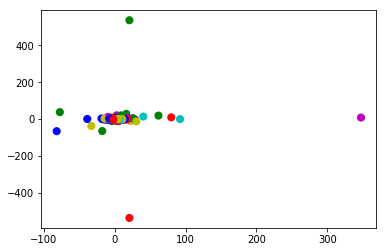

In [11]:
# Visualize the tSNE 2d projection
plt.scatter(tsne_components[:,0], tsne_components[:,1], c=colors, s=50)
plt.show()

In [12]:
# Take a look at the labels distribution
print('--------------------Dataset Labels Distribution--------------------')
rows, cols = tsne_labels_df.shape
print(tsne_labels_df.groupby('Label').count())
print('Total number of inputs: %s' % rows)

--------------------Dataset Labels Distribution--------------------
          Col 1  Col 2  Col 3  Col 4  Col 5  Col 6  Col 7  Col 8  Col 9  \
Label                                                                     
ANGER        71     71     71     71     71     71     71     71     71   
DISGUST      69     69     69     69     69     69     69     69     69   
FEAR         70     70     70     70     70     70     70     70     70   
HAPPY       106    106    106    106    106    106    106    106    106   
SADNESS      66     66     66     66     66     66     66     66     66   
SURPRISE     71     71     71     71     71     71     71     71     71   

          Col 10  Col 11  Col 12  Col 13  Col 14  
Label                                             
ANGER         71      71      71      71      71  
DISGUST       69      69      69      69      69  
FEAR          70      70      70      70      70  
HAPPY        106     106     106     106     106  
SADNESS       66      66 

# Prepare Data for classification
Balance classes for training from dimensionality reduction process.

## Classifications
Two simple unsupervised methods: KNN and SVM.

In [13]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

def get_train_test_split(df):
    '''
    Split data into training and test sets
    '''
    # Shuffle data frame
    df = df.sample(frac=1)
    # Select same num per class, remaining go to test set
    num_of_inputs = 63
    cols = ['Label'] + column_names
    train_df, test_df = (pd.DataFrame(columns=cols), pd.DataFrame(columns=cols))
    for x in targets:
        train_df = train_df.append(df.loc[df['Label'] == x][0:num_of_inputs], ignore_index=True)
        test_df = test_df.append(df.loc[df['Label'] == x][num_of_inputs:], ignore_index=True)

    # Shuffle data frames
    train_df = train_df.sample(frac=1)
    test_df = test_df.sample(frac=1)
    
    return train_df, test_df

runs = 100
knn_scores = []
svm_scores = []
for index in range(runs):
    train_df, test_df = get_train_test_split(principal_labels_df)

    # Split train and test labels/data
    train_data   = train_df.iloc[:,1:].values
    train_labels = train_df.iloc[:,:1].values.ravel()

    test_data   = test_df.iloc[:,1:].values
    test_labels = test_df.iloc[:,:1].values.ravel()
    
    # Just print once
    if index == 0:
        # Take a look at the labels distribution
        print('--------------------Training--------------------')
        rows, cols = train_df.shape
        print(train_df.groupby('Label').count())
        print('Total number of inputs: %s' % rows)

        print('--------------------Testing--------------------')
        rows, cols = test_df.shape
        print(test_df.groupby('Label').count())
        print('Total number of inputs: %s' % rows)
        
    # Classifications

    # Use KNN to predict
    kNNClassifier = neighbors.KNeighborsClassifier(n_neighbors=10).fit(train_data, train_labels)
    predicted_labels = kNNClassifier.predict(test_data)
    acc_knn = accuracy_score(test_labels, predicted_labels)
    knn_scores.append(acc_knn)

    # Use SVM to predict
    clf_svm = LinearSVC()
    clf_svm.fit(train_data, train_labels)
    predicted_labels = clf_svm.predict(test_data)
    acc_svm = accuracy_score(test_labels, predicted_labels)
    svm_scores.append(acc_svm)
 
print('--------------------Result--------------------')
print("kNN classifier accuracy: %.02f%%" % (sum(knn_scores) / runs))      
print("SVM classifier accuracy: %.02f%%" % (sum(svm_scores) / runs))

--------------------Training--------------------
          Col 1  Col 2  Col 3  Col 4  Col 5  Col 6  Col 7  Col 8  Col 9  \
Label                                                                     
ANGER        63     63     63     63     63     63     63     63     63   
DISGUST      63     63     63     63     63     63     63     63     63   
FEAR         63     63     63     63     63     63     63     63     63   
HAPPY        63     63     63     63     63     63     63     63     63   
SADNESS      63     63     63     63     63     63     63     63     63   
SURPRISE     63     63     63     63     63     63     63     63     63   

          Col 10  Col 11  Col 12  Col 13  Col 14  
Label                                             
ANGER         63      63      63      63      63  
DISGUST       63      63      63      63      63  
FEAR          63      63      63      63      63  
HAPPY         63      63      63      63      63  
SADNESS       63      63      63      63    